In [1]:
import pandas as pd
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
counts = {
    'B_CD8T': 474521,
    'B_T': 1435388,
    'PBMC_all': 2238732,
    'TCells': 1280445,
    'PBMC5K': 72208619,
    'Chen': 22331703,
    'Camp': 2762889,
    'HLCA_aorta': 1026532,
    'HLCA_lung': 4317000,
    'HLCA_marrow': 15854124,
    'CellLines': 5516980,
    'HSC': 13634167,
    'FibrocardRNA': 50000000,
    'FibrocardATAC': 138840495, 
}

In [3]:
def get_category(x):
    return f'{x["method"]}{x["dataset"]}{x["metric"]}'

def get_category_lookup(x):
    return f'dense_GPU{x["dataset"]}{x["metric"]}'

def vlookup(df, x):
    return df.set_index('cated').loc[x['vlookup_cated'], 'mean']

In [4]:
def get_input_data(from_range, to_range):

    outputs = []

    for dataset in [
        'B_T', 'B_CD8T', 'PBMC_all', 'TCells', 'PBMC5K', 'Chen', 'Camp', 'HSC', 'HLCA_aorta', 'HLCA_lung', 'HLCA_marrow', 'CellLines',
        'FibrocardRNA', 'FibrocardATAC'
    ]:
        for method in ['dense_amap', 'dense_factoextra', 'dense_CPU', 'dense_GPU', 'sparse_CPU', 'sparse_GPU', 'dense_pythonic', 'dense_pandas']:
            metric = 'kendall'
            filename = f'../results/RealDatasets/{dataset}/{method}_{metric}.csv'
#             print(filename)
            if not os.path.exists(filename):
                if method == 'dense_pythonic':
                    method_new = 'scipy'
                else:
                    method_new = method
                output = {
                    'metric': metric,
                    'dataset': dataset,
                    'mean': 10 ** 11,
                    'method': method_new,
                    'missing': True
                }
            else:
                df = pd.read_csv(filename)
                values = df.loc[from_range:to_range, df.columns[0]]

                if len(values) == 0:
                    values = df.loc[df.shape[0] - 1, df.columns[0]]

                mean_value = values[values > 0].mean()
                if method == 'dense_pythonic':
                    method_new = 'scipy'
                    mean_value *= 24
                else:
                    method_new = method

                output = {
                    'metric': metric,
                    'dataset': dataset,
                    'mean': mean_value,
                    'log_mean': np.log10(mean_value),
                    'method': method_new,
                    'missing': False,
                }

            outputs.append(output)
    df_updated = pd.DataFrame(outputs)
    df_updated['cated'] = df_updated.apply(get_category, axis=1)
    df_updated['vlookup_cated'] = df_updated.apply(get_category_lookup, axis=1)
    
    df_updated['base'] = df_updated.apply(lambda x: vlookup(df_updated, x), axis=1)
    df_updated['acceleration'] = df_updated['base'] / df_updated['mean']
    df_updated.loc[df_updated.method == 'scipy', 'method'] = 'scipy'
    df_updated.loc[df_updated.method == 'dense_pandas', 'method'] = 'pandas'
    df_updated.loc[df_updated.method == 'dense_CPU', 'method'] = 'CPU'
    df_updated.loc[df_updated.method == 'dense_factoextra', 'method'] = 'factoextra'
    df_updated.loc[df_updated.method == 'dense_amap', 'method'] = 'amap'
    df_updated.loc[df_updated.method == 'dense_raft', 'method'] = 'raft-dense'
    df_updated.loc[df_updated.method == 'sparse_raft', 'method'] = 'raft-sparse'
    df_updated.loc[df_updated['method'] == 'CPU', 'method'] = 'GADES-CPU-dense'
    df_updated.loc[df_updated['method'] == 'dense_GPU', 'method'] = 'GADES-GPU-dense'
    df_updated.loc[df_updated['method'] == 'sparse_GPU', 'method'] = 'GADES-GPU-sparse'
    df_updated.loc[df_updated['method'] == 'sparse_CPU', 'method'] = 'GADES-CPU-sparse'
    df_updated.loc[df_updated['method'] == 'dense_raft', 'method'] = 'raft'
    df_updated['log_acceleration'] = df_updated.acceleration.apply(lambda x: np.log10(x))
    return df_updated

In [5]:
all_df = get_input_data(0, 1)

In [6]:
all_df_sequential = get_input_data(0, 100)

In [7]:
import seaborn as sns

In [8]:
df_missing_counts = all_df[all_df.missing].groupby(['metric', 'method']).count()

In [9]:
missing_pivot = df_missing_counts.reset_index().pivot(index='metric', columns='method', values='dataset')
missing_pivot = missing_pivot.fillna(0.1)

In [10]:
df_missing_unmelt = pd.melt(missing_pivot, ignore_index=False).reset_index()

In [11]:
remapping = {
    'dense_CPU': 'GADES-CPU-dense',
    'sparse_CPU': 'GADES-CPU-sparse',
    'dense_GPU': 'GADES-GPU-dense',
    'sparse_GPU': 'GADES-GPU-sparse',
    'dense_amap': 'amap',
    'scipy': 'scipy',
    'dense_pandas': 'pandas',
    'dense_factoextra': 'factoextra',
}

# Acceleration Load

In [12]:
import matplotlib.pyplot as plt

df_test = all_df.copy()

df_test.loc[df_test.missing, 'log_mean'] = 0.1

In [13]:
methods = ['amap', 'factoextra', 'scipy', 'pandas', 'GADES-CPU-dense', 'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse']

In [14]:
df_all_melt = df_missing_unmelt.copy()

In [15]:
df_all_melt['value'] = 14

In [16]:
df_all_melt['metric'] = '_' + df_all_melt['metric']

In [17]:
palette = sns.palettes.color_palette()[:len(methods)]
color_palette = {
    method: pallete for method, pallete in zip(methods, palette)
}

# Figure 5

In [18]:
all_df['method'].unique()

array(['amap', 'factoextra', 'GADES-CPU-dense', 'GADES-GPU-dense',
       'GADES-CPU-sparse', 'GADES-GPU-sparse', 'scipy', 'pandas'],
      dtype=object)

In [19]:
color_palette['GADES-GPU-dense'] = color_palette['GADES-GPU-dense']

In [20]:
methods = ['amap', 'factoextra', 'scipy', 'pandas', 'GADES-CPU-dense', 'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse']

In [21]:
def redraw_hatches_and_colors(ax):
    rectangles = [p for p in ax.patches if isinstance(p, Rectangle)]
    
    for rectangle in rectangles:
        rectangle.set_facecolor('gray')
        rectangle.set_alpha(0.5)

In [22]:
all_df[all_df['method'] == 'scipy']

,metric,dataset,mean,method,missing,log_mean,cated,vlookup_cated,base,acceleration,log_acceleration
6,kendall,B_T,2.467702e+09,scipy,False,9.392293,scipyB_Tkendall,dense_GPUB_Tkendall,5.944010e+08,0.240872,-0.618213
14,kendall,B_CD8T,2.875436e+08,scipy,False,8.458704,scipyB_CD8Tkendall,dense_GPUB_CD8Tkendall,4.662984e+07,0.162166,-0.790040
22,kendall,PBMC_all,2.090422e+10,scipy,False,10.320234,scipyPBMC_allkendall,dense_GPUPBMC_allkendall,7.918519e+09,0.378800,-0.421590
30,kendall,TCells,3.080052e+09,scipy,False,9.488558,scipyTCellskendall,dense_GPUTCellskendall,1.415237e+09,0.459485,-0.337729
38,kendall,PBMC5K,1.000000e+11,scipy,True,NaN,scipyPBMC5Kkendall,dense_GPUPBMC5Kkendall,1.000000e+11,1.000000,0.000000
46,kendall,Chen,1.000000e+11,scipy,True,NaN,scipyChenkendall,dense_GPUChenkendall,1.000000e+11,1.000000,0.000000
54,kendall,Camp,8.194831e+08,scipy,False,8.913540,scipyCampkendall,dense_GPUCampkendall,1.645645e+08,0.200815,-0.697204
62,kendall,HSC,1.000000e+11,scipy,True,NaN,scipyHSCkendall,dense_GPUHSCkendall,1.000000e+11,1.000000,0.000000
70,kendall,HLCA_aorta,3.584102e+08,scipy,False,8.554380,scipyHLCA_aortakendall,dense_GPUHLCA_aortakendall,7.285703e+07,0.203278,-0.691909
78,kendall,HLCA_lung,5.025832e+09,scipy,False,9.701208,scipyHLCA_lungkendall,dense_GPUHLCA_lungkendall,1.803512e+09,0.358849,-0.445089


In [23]:
df_missing_unmelt['method'].unique()

array(['GADES-CPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-dense',
       'GADES-GPU-sparse', 'amap', 'factoextra', 'pandas', 'scipy'],
      dtype=object)

In [24]:
from matplotlib.patches import FancyBboxPatch


def draw_round_borders(current_ax, **kwargs):

    
    bbox = current_ax.get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
    xpad = 0.05 * width
    ypad = 0.05 * height
    fig.add_artist(
        FancyBboxPatch(
            (x0- 0.5 * xpad, y0 - 0.4 * ypad), width - 4 * xpad, height=height+ 1.0 * ypad, edgecolor='black', linewidth=4, fill=False,
            boxstyle='round,pad=-0.0040,rounding_size=0.02',
            mutation_aspect=3,
        )
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes.ArtistList of 8 patches>


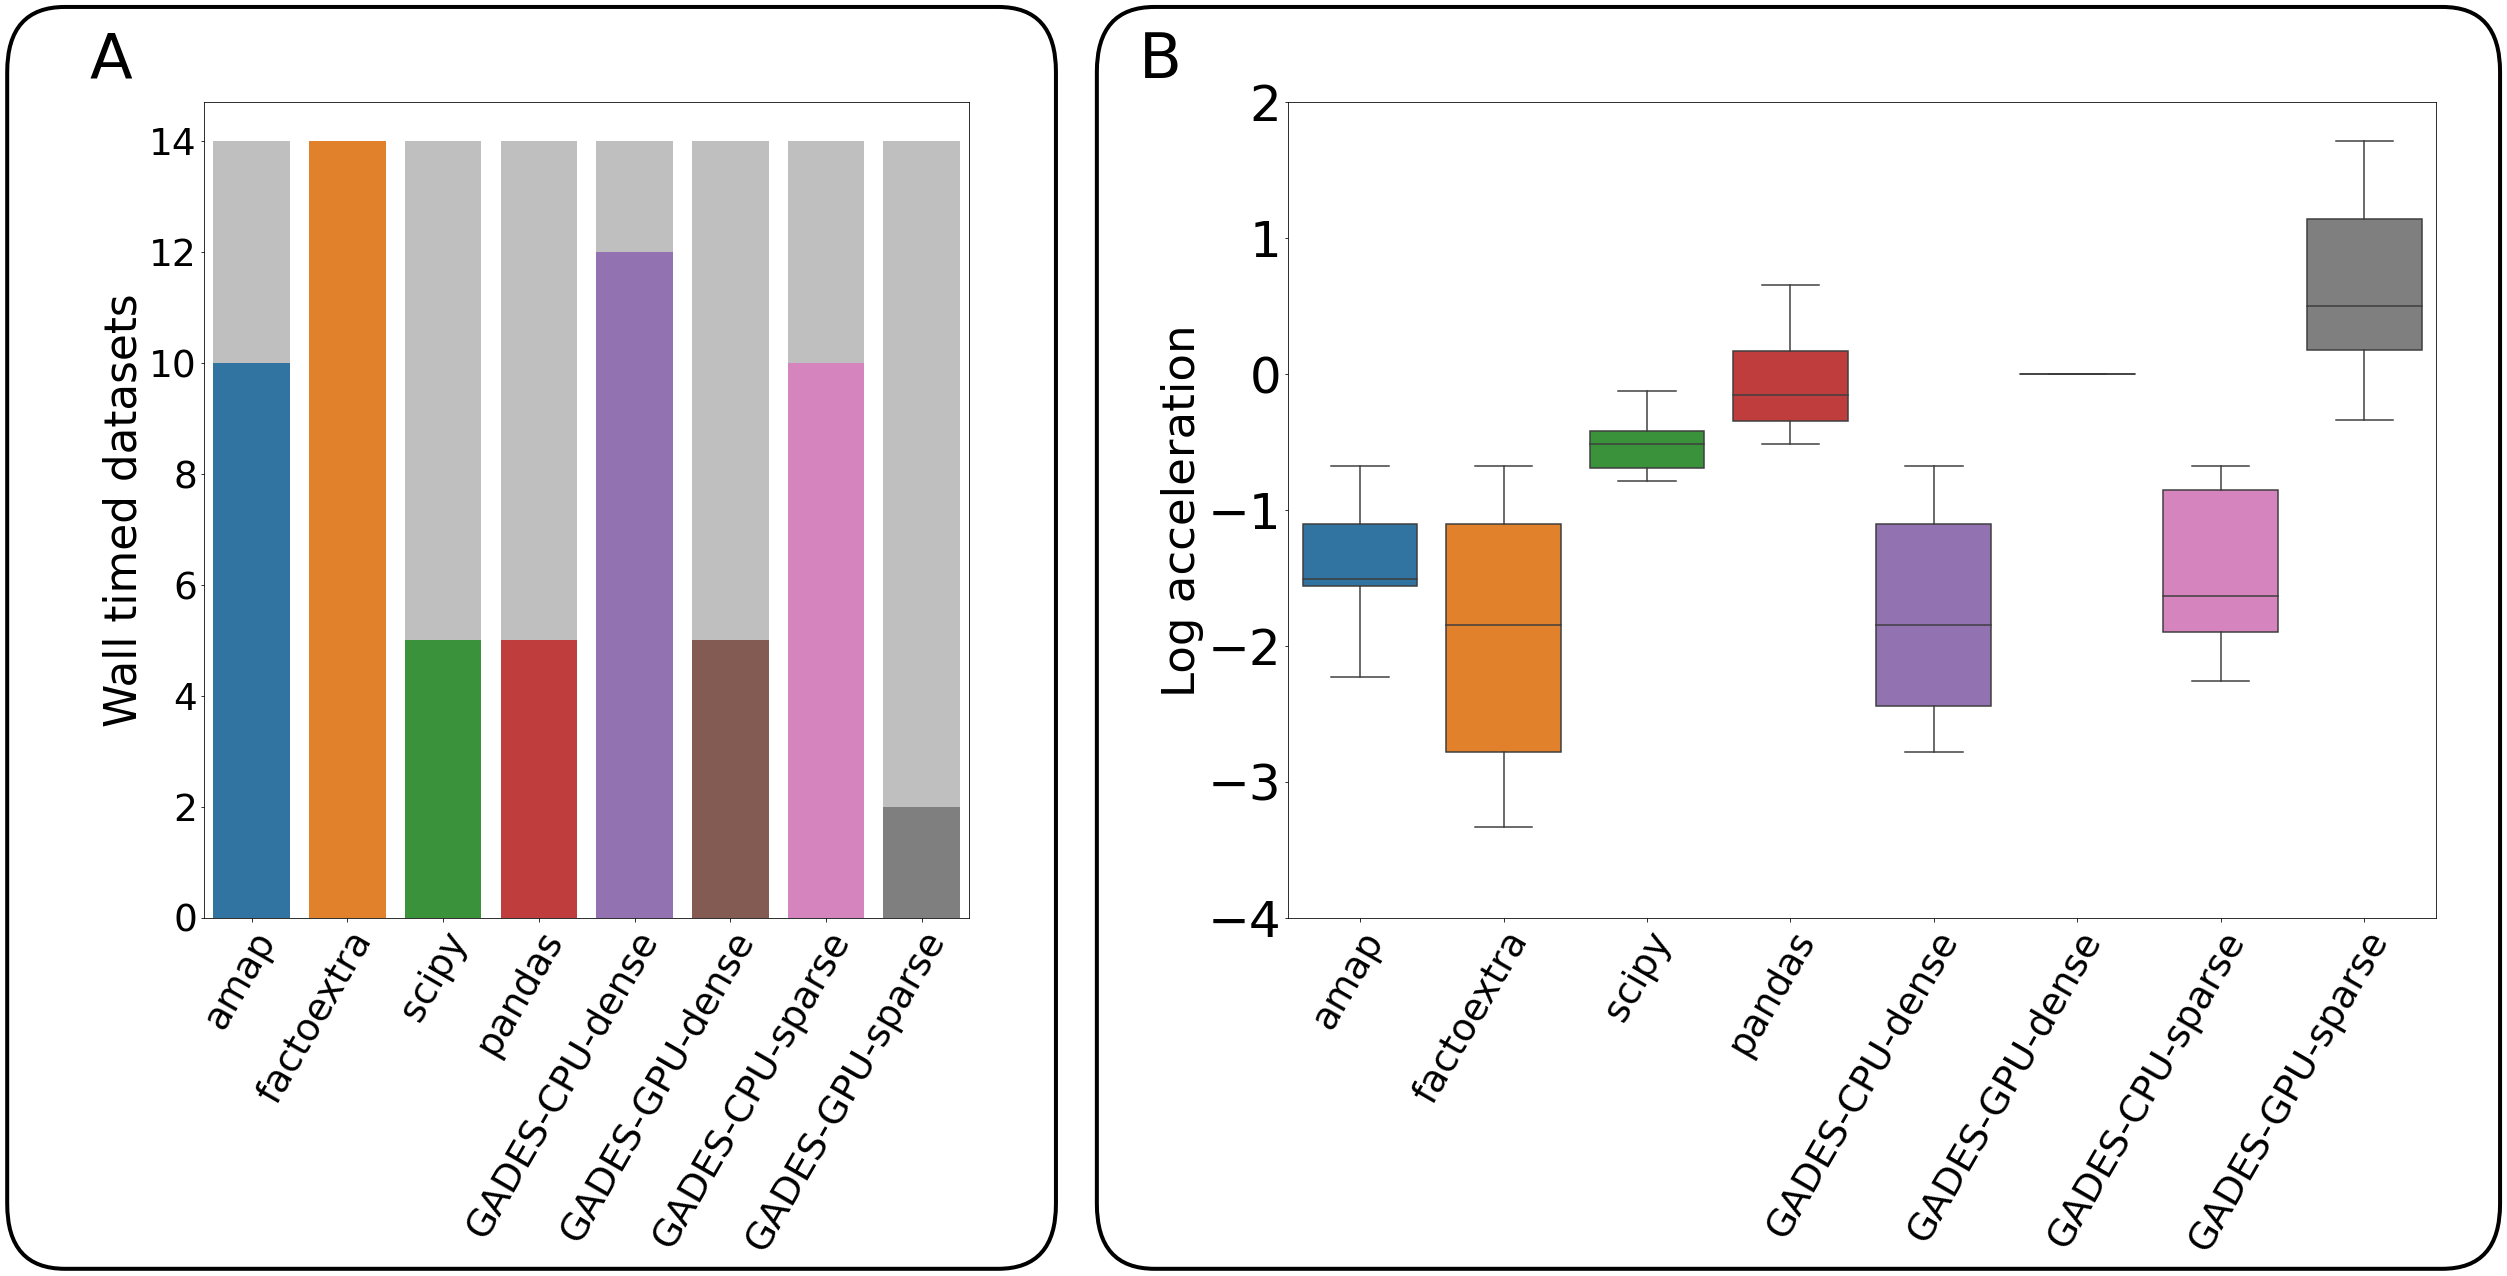

In [25]:
from matplotlib.gridspec import GridSpec

from matplotlib.patches import PathPatch, Rectangle
fig = plt.figure(figsize=(40, 15))

gs = GridSpec(1, 4, figure=fig, width_ratios=[1.5, 0.333, 0.333, 0.333]
             )

BASE_FONT_SIZE = 25
SCALE = 1.7

FONT_SIZE = BASE_FONT_SIZE * SCALE

current_ax = fig.add_subplot(gs[0])

plot = sns.barplot(
    ax=current_ax,
    data=df_all_melt, hue='metric', y='value', x='method',
    order=methods,
    hue_order=['_kendall'],
    zorder=0,
)
print(current_ax.patches)
plot.get_legend().remove()
redraw_hatches_and_colors(current_ax)

plot = sns.barplot(
    ax=current_ax,
    data=df_missing_unmelt[df_missing_unmelt['metric'] == 'kendall'],y='value', x='method',
    order=methods,
#     hue_order=['kendall'],
    palette=color_palette,
    zorder=2,
)


plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_ylabel(f'Wall timed datasets', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.15, 1.03, 'A', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)
metric = 'kendall'
draw_round_borders(current_ax)

current_ax = fig.add_subplot(gs[1:])
plot = sns.boxplot(
    ax=current_ax,
    data=all_df[((all_df['method'] == 'GADES-GPU-dense') | (all_df.log_acceleration != 0)) & (all_df.metric == metric)], y='log_acceleration',
    x='method',
    order=[
        'amap',
        'factoextra',
        'scipy',
        'pandas',
        'GADES-CPU-dense',
        'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse'
    ],
)

plot.tick_params(labelsize=BASE_FONT_SIZE * 1.25)
current_ax.set_ylim(-4, 2)

plot.set_ylabel(f'Log acceleration', fontsize=BASE_FONT_SIZE * 1.8)
plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.13, 1.03, 'B', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=BASE_FONT_SIZE)
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 2)
current_ax.legend(fontsize=BASE_FONT_SIZE * 1.5, bbox_to_anchor=(1, 1))
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')
# draw_round_borders(current_ax)
# fig.suptitle('Reinitialization', size=BASE_FONT_SIZE * 2, y=1.05)
fig.subplots_adjust(wspace = 1.0)
fig.subplots_adjust(hspace=0.3)
bbox = current_ax.get_tightbbox(fig.canvas.get_renderer())
x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
# slightly increase the very tight bounds:
xpad = 0.05 * width
ypad = 0.05 * height
fig.add_artist(
    FancyBboxPatch(
        (x0- 0.8 * xpad, y0 - 0.4 * ypad), width + 1.2 * xpad, height=height+ 1.0 * ypad, edgecolor='black', linewidth=4, fill=False,
        boxstyle='round,pad=-0.0040,rounding_size=0.02',
        mutation_aspect=3,
    )
)
current_ax.get_legend().remove()


plt.savefig(f'figure5.png', bbox_inches='tight', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes.ArtistList of 8 patches>


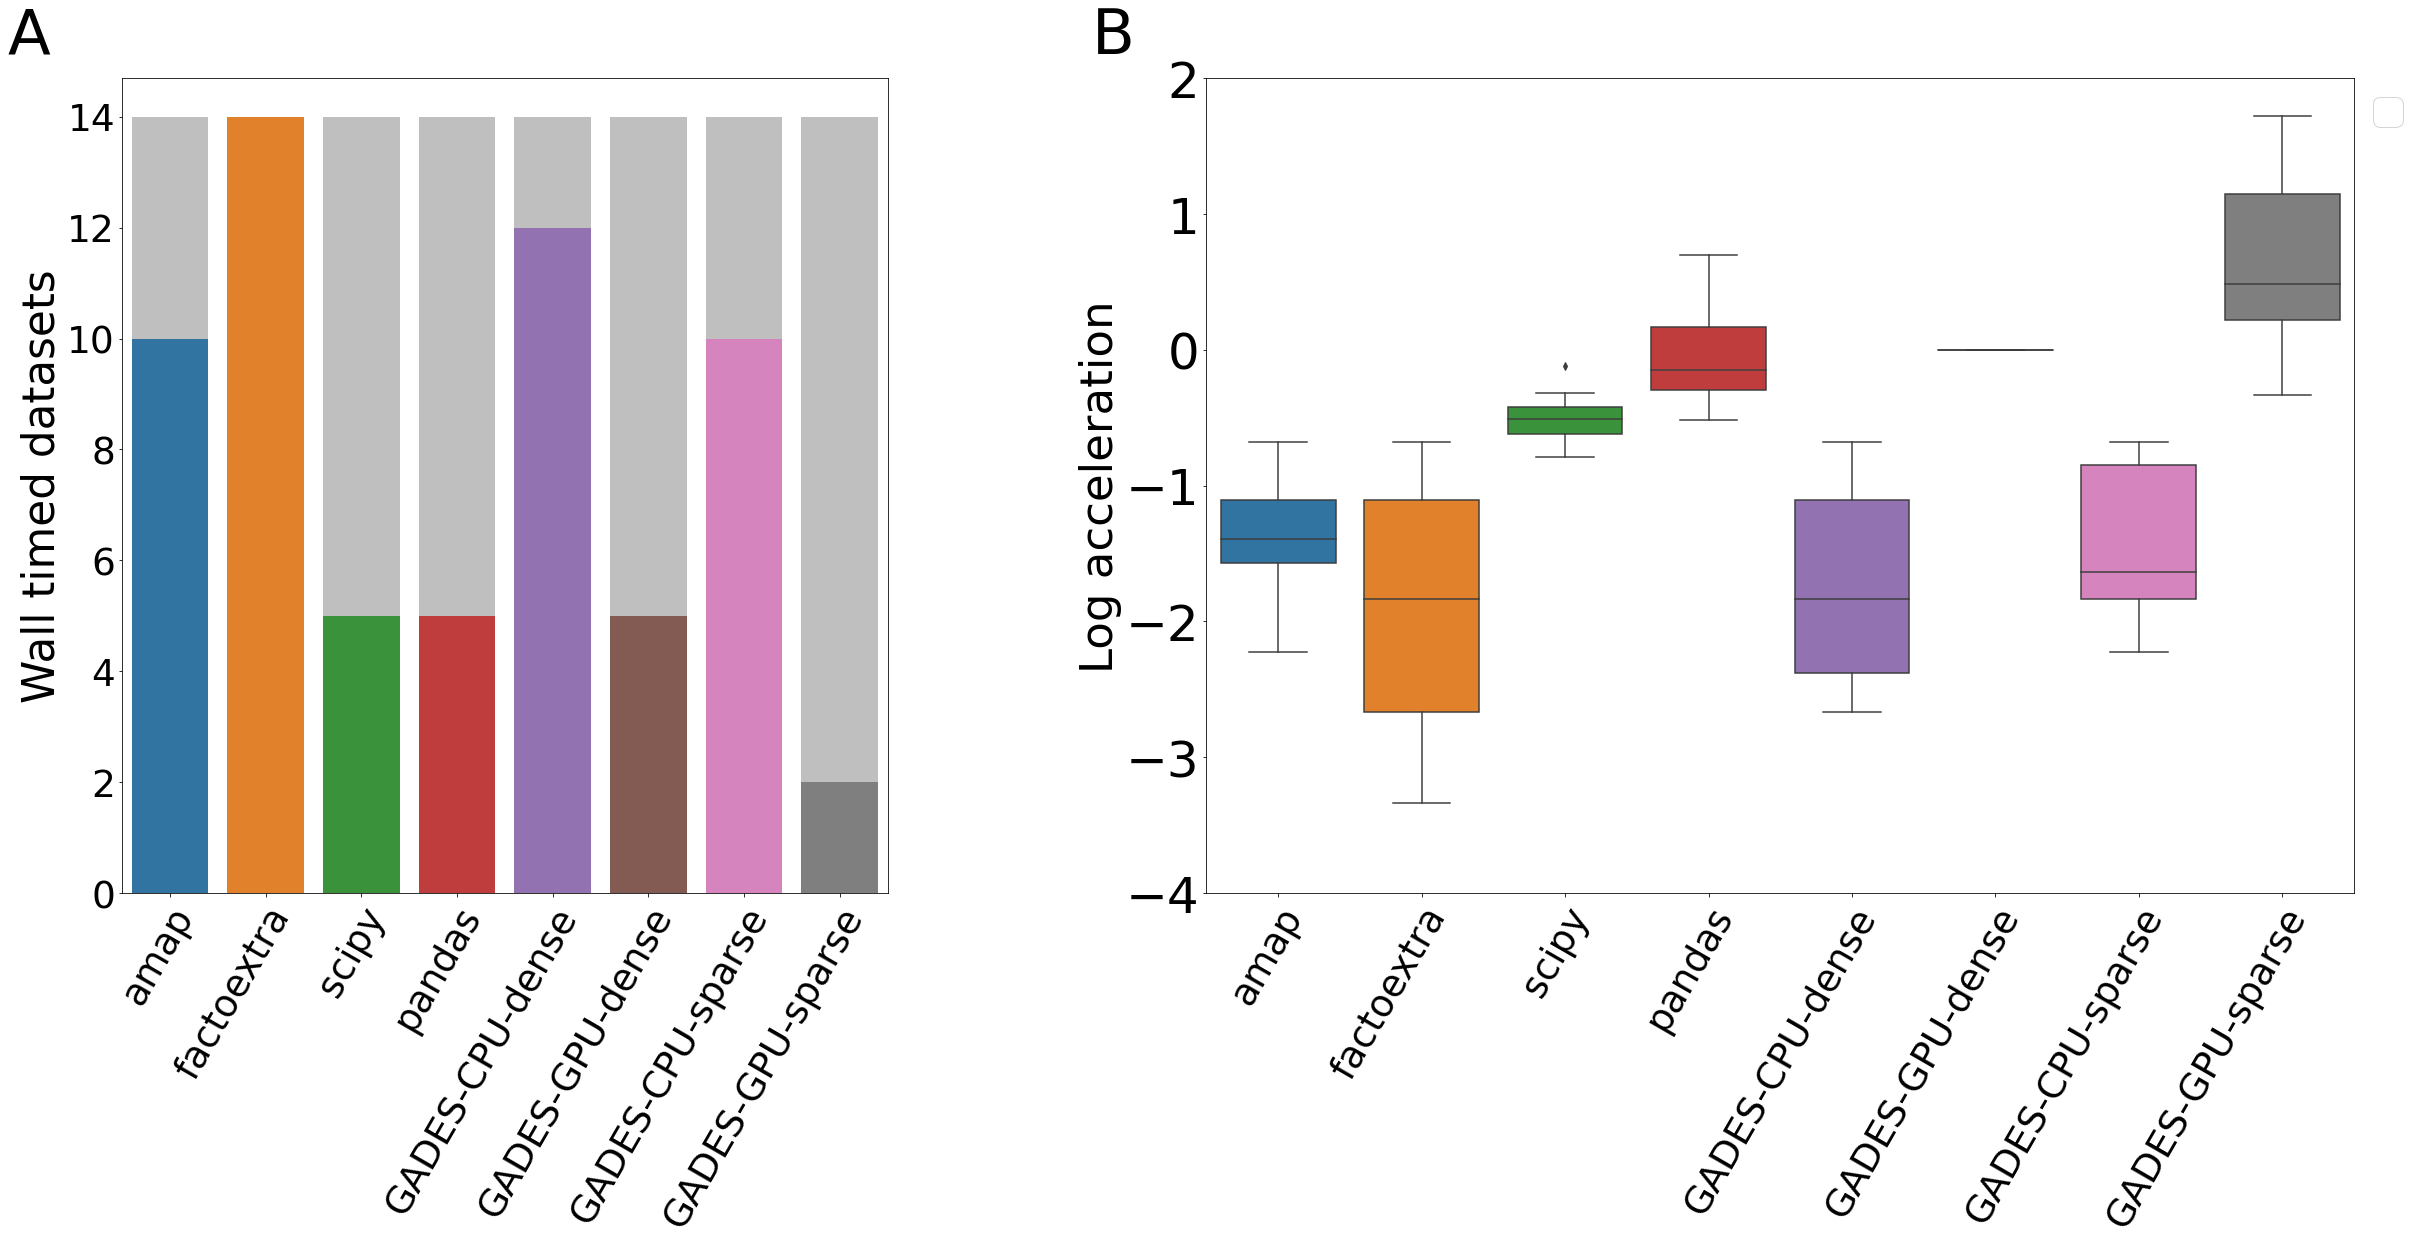

In [26]:
from matplotlib.gridspec import GridSpec

from matplotlib.patches import PathPatch, Rectangle
fig = plt.figure(figsize=(40, 15))

gs = GridSpec(1, 4, figure=fig, width_ratios=[1.5, 0.333, 0.333, 0.333]
             )

BASE_FONT_SIZE = 25
SCALE = 1.7

FONT_SIZE = BASE_FONT_SIZE * SCALE

current_ax = fig.add_subplot(gs[0])

plot = sns.barplot(
    ax=current_ax,
    data=df_all_melt, hue='metric', y='value', x='method',
    order=methods,
    hue_order=['_kendall'],
    zorder=0,
)
print(current_ax.patches)
plot.get_legend().remove()
redraw_hatches_and_colors(current_ax)


plot = sns.barplot(
    ax=current_ax,
    data=df_missing_unmelt[df_missing_unmelt['metric'] == 'kendall'],y='value', x='method',
    order=methods,
    palette=color_palette,
    zorder=2,
)


plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_ylabel(f'Wall timed datasets', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.15, 1.03, 'A', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)

metric = 'kendall'
current_ax = fig.add_subplot(gs[1:])
plot = sns.boxplot(
    ax=current_ax,
    data=all_df_sequential[((all_df_sequential['method'] == 'GADES-GPU-dense') | (all_df_sequential.log_acceleration != 0)) & (all_df_sequential.metric == metric)], y='log_acceleration',
    x='method',
    order=[
        'amap',
        'factoextra',
        'scipy',
        'pandas',
        'GADES-CPU-dense',
        'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse'
    ],
)

plot.tick_params(labelsize=BASE_FONT_SIZE * 1.25)
current_ax.set_ylim(-4, 2)

plot.set_ylabel(f'Log acceleration', fontsize=BASE_FONT_SIZE * 1.8)
plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.1, 1.03, 'B', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=BASE_FONT_SIZE)
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 2)
current_ax.legend(fontsize=BASE_FONT_SIZE * 1.5, bbox_to_anchor=(1, 1))
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')


fig.subplots_adjust(wspace = 1.0)
fig.subplots_adjust(hspace=0.3)

plt.savefig(f'figure5-sequential.png', bbox_inches='tight', dpi=200)